<a href="https://colab.research.google.com/github/baovin/ML_homework/blob/main/Copy_of_01_RNN_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# cài thư viện d2l
!pip install d2l==0.16.5

# For d2l 0.16.5, please refer to https://github.com/d2l-ai/d2l-en/blob/v0.16.5/d2l/torch.py

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
  Attemptin

# Implementation of Recurrent Neural Networks from Scratch

Trong phần này, chúng ta lập trình từ đầu mô hình ngôn ngữ. Mô hình này dựa trên mạng nơ-ron hồi tiếp ở cấp độ ký tự (character-level) được huấn luyện trên tiểu thuyết The Time Machine (Cỗ máy thời gian) của H. G. Wells. Cũng như trước, ta bắt đầu với việc đọc tập dữ liệu...


In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
vocab.token_to_idx, train_iter.corpus[:10]

({'<unk>': 0,
  ' ': 1,
  'e': 2,
  't': 3,
  'a': 4,
  'i': 5,
  'n': 6,
  'o': 7,
  's': 8,
  'h': 9,
  'r': 10,
  'd': 11,
  'l': 12,
  'm': 13,
  'u': 14,
  'c': 15,
  'f': 16,
  'w': 17,
  'g': 18,
  'y': 19,
  'p': 20,
  'b': 21,
  'v': 22,
  'k': 23,
  'x': 24,
  'z': 25,
  'j': 26,
  'q': 27},
 [3, 9, 2, 1, 3, 5, 13, 2, 1, 13])

In [4]:
vocab['a'], vocab.idx_to_token[0]

(4, '<unk>')

## One-Hot Encoding



Lưu ý rằng mỗi token được biểu diễn bằng một chỉ số (numerical index) trong `train_iter`. Đưa trực tiếp các chỉ số này vào mạng nơ-ron sẽ gây khó khăn cho việc học. Do đó, mỗi token thường được biểu diễn dưới dạng một vector đặc trưng mang nhiều thông tin hơn. Cách đơn giản nhất là sử dụng biểu diễn one-hot (one-hot encoding).

Nói ngắn gọn, ta ánh xạ mỗi chỉ số thành một vector đơn vị khác nhau: giả sử số token không trùng lặp trong bộ từ vựng là  $N$  (len(vocab)) và chỉ số của chúng nằm trong khoảng từ 0 đến  $N−1$ . Với token chỉ số  $i$ , ta tạo một vector  độ dài  $N$ có các phần tử bằng 0, trừ phần tử ở vị trí  $i$  bằng 1. Vector này là vector one-hot của token gốc. Các vector one-hot với các chỉ số 0 và 2 được minh họa phía dưới.

In [5]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])




Kích thước minibatch mà chúng ta lấy mẫu mỗi lần là (kích thước batch, bước thời gian). Hàm one_hot biến đổi một minibatch như vậy thành một tensor 3 chiều với kích thước chiều cuối cùng bằng kích thước bộ từ vựng. Chúng ta thường chuyển vị đầu vào để có đầu ra với kích thước (bước thời gian, kích thước batch, kích thước bộ từ vựng), phù hợp hơn để đưa vào mô hình chuỗi.

In [6]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters
Tiếp theo, ta khởi tạo các tham số cho mô hình RNN. Số nút ẩn $num_hiddens$ là tham số có thể điều chỉnh. Khi huấn luyện mô hình ngôn ngữ trong bài này, inputs và outputs đều dựa vào cùng một từ điển, do đó, chúng sẽ có cùng chiều (và bằng vocab size)


In [9]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

Đầu tiên, chúng ta khởi tạo trạng thái ẩn bằng hàm `init_rnn_state`. Hàm này trả về tuple gồm một ndarray chứa giá trị 0 và có kích thước là (kích thước batch, số nút ẩn). Trả về tuple giúp ta dễ dàng xử lý các tình huống khi trạng thái ẩn chứa nhiều biến (ví dụ: khi ta cần khởi tạo nhiều tầng được kết hợp trong RNN).


In [10]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

Hàm rnn sau định nghĩa cách tính toán trạng thái ẩn và đầu ra tại một bước thời gian. Hàm kích hoạt ở đây là  tanh. Giá trị trung bình của hàm  tanh  là 0, khi các phần tử được phân bổ đều trên trục số thực.


In [11]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

Sau khi đã định nghĩa tất cả các hàm, ta tạo một lớp để bao các hàm này lại và lưu trữ các tham số.



In [12]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Hãy kiểm tra nhanh chiều của đầu vào và đầu ra, và xem chiều của trạng thái ẩn có thay đổi hay không.

In [13]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

Có thể thấy kích thước đầu ra là (số time steps  ×  kích thước batch, kích thước bộ từ vựng), trong khi kích thước trạng thái ẩn vẫn giữ nguyên là (kích thước batch, số nút ẩn).

## Prediction

Trước tiên chúng ta giải thích hàm dự đoán thường xuyên được dùng để kiểm tra trong quá trình huấn luyện. Hàm này dự đoán `num_predicts` ký tự tiếp theo dựa trên `prefix` (một chuỗi chứa một vài ký tự). Ở các ký tự đầu tiên trong chuỗi, ta chỉ cập nhật trạng thái ẩn rồi sau đó mới bắt đầu tạo ra các ký tự mới.


In [15]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Ta chạy thử hàm `predict_ch8` trước. Lúc này đầu ra sẽ là các dự đoán vô nghĩa do mạng chưa được huấn luyện. Ta khởi tạo mạng với chuỗi `traveller` và cho nó tạo ra thêm 10 ký tự.

In [16]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller fmpthyhe w'

## Gradient Clipping

Với chuỗi độ dài  T , trong một vòng lặp lan truyền ngược ta tính toán gradient qua  $T$  bước thời gian, dẫn đến một chuỗi các tích của ma trận có độ phức tạp  $O(T)$ . Khi  $T$  lớn việc này có thể dẫn đến mất ổn định số học, biểu hiện qua hiện tượng bùng nổ hoặc tiêu biến gradient. Do đó, các mô hình RNN thường cần một chút hỗ trợ để ổn định việc huấn luyện.

Nhớ lại rằng khi giải quyết vấn đề tối ưu, ta thực hiện cập nhật trọng số  $w$  ngược hướng gradient  $g_t$  trên một minibatch, theo công thức  $w−η⋅g_t$ . Giả sử hàm mục tiêu là hàm liên tục Lipschitz với hằng số  $L$ , tức:

$$|l(\mathbf{w}) - l(\mathbf{w}')| \leq L \|\mathbf{w} - \mathbf{w}'\|.$$

Trong trường hợp này, có thể nói khi cập nhật vector trọng số theo  $η⋅g_t$ , sự thay đổi sẽ không lớn hơn  $Lη∥gt∥$ . Điều này vừa có lợi vừa có hại. Có hại ở chỗ tốc độ tối ưu bị giới hạn, có lợi ở chỗ mức độ sai lệch khi tối ưu sai hướng cũng bị hạn chế.

Đôi khi gradient có thể khá lớn và do đó thuật toán tối ưu không hội tụ. Vấn đề này có thể được giải quyết bằng cách giảm tốc độ học  $η$  hoặc sử dụng một số thủ thuật liên quan tới đạo hàm bậc cao hơn. Nhưng nếu gradient hiếm khi đạt giá trị lớn, cách giải quyết như vậy không đảm bảo hội tụ hoàn toàn. Một cách khác là gọt gradient (gradient clipping) bằng cách chiếu gradient lên mặt cầu bán kính  $θ$  qua công thức:

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

Như vậy chuẩn của gradient sẽ không vượt quá  $θ$  và gradient sau khi gọt sẽ cùng hướng gradient  $g$  ban đầu. Gọt gradient có tác dụng phụ tích cực là hạn chế ảnh hưởng quá lớn của bất kỳ minibatch nào (hoặc bất kỳ mẫu nào) lên các trọng số, làm cho mô hình ổn định hơn. Dù không giải quyết được hoàn toàn vấn đề, đây là một kỹ thuật đơn giản để làm giảm nhẹ vấn đề bùng nổ gradient.

Dưới đây, ta định nghĩa hàm gọt gradient, dùng cho cả mô hình lập trình từ đầu RNNModelScratch và mô hình tạo bằng Gluon. Lưu ý rằng ta tính chuẩn của gradient trên tất cả các tham số.





In [17]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training

Trước tiên, ta định nghĩa hàm huấn luyện trên một epoch dữ liệu. Qúa trình huấn luyện sẽ khác với bài softmax ở 3 điểm :

- Các phương pháp lấy mẫu khác nhau cho dữ liệu tuần tự (lấy mẫu ngẫu nhiên và phân tách tuần tự) sẽ dẫn đến sự khác biệt trong việc khởi tạo các trạng thái ẩn.
- Ta gọt gradient trước khi cập nhật tham số mô hình. Việc này đảm bảo rằng mô hình sẽ không phân kỳ ngay cả khi gradient bùng nổ tại một thời điểm nào đó trong quá trình huấn luyện, đồng thời tự động giảm biên độ của bước cập nhật một cách hiệu quả.
- Ta sử dụng perplexity để đánh giá mô hình. Phương pháp này đảm bảo rằng các chuỗi có độ dài khác nhau có thể so sánh được.

Khi thực hiện lấy mẫu tuần tự, ta chỉ khởi tạo trạng thái ẩn khi bắt đầu mỗi epoch. Vì mẫu thứ  $i^t$  trong minibatch tiếp theo liền kề với mẫu thứ  $i^t$  trong minibatch hiện tại nên ta có thể sử dụng trực tiếp trạng thái ẩn hiện tại cho minibatch tiếp theo, chỉ cần tách gradient để tính riêng cho mỗi minibatch. Còn khi thực hiện lấy mẫu ngẫu nhiên, ta cần tái khởi tạo trạng thái ẩn cho mỗi vòng lặp vì mỗi mẫu được lấy ra ở vị trí ngẫu nhiên.

In [18]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

Hàm huấn luyện này hỗ trợ cả mô hình sử dụng Gluon và mô hình lập trình từ đầu.



In [19]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Bây giờ ta có thể huấn luyện mô hình. Do chỉ sử dụng  10.000  token trong tập dữ liệu, mô hình này cần nhiều epoch hơn để hội tụ.

perplexity 1.0, 95774.5 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


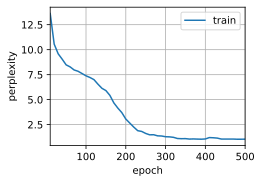

In [20]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Cuối cùng, ta kiểm tra kết quả khi lấy mẫu ngẫu nhiên.



perplexity 1.4, 94230.2 tokens/sec on cuda:0
time traveller smiled are you sure we can move freely inspace ri
traveller after the pauserequired for the proper assimilati


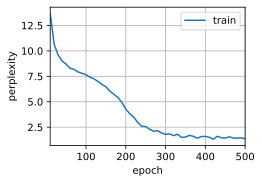

In [21]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

Mặc dù học được nhiều điều từ việc lập trình từ đầu nhưng cách làm này không thực sự tiện lợi. Trong phần tiếp theo, ta sẽ tìm hiểu cách cải thiện đáng kể mô hình hiện tại, nhanh và dễ lập trình hơn.


## Summary

- Mô hình chuỗi cần khởi tạo trạng thái cho quá trình huấn luyện.
- Giữa các mô hình chuỗi, ta cần đảm bảo tách gradient để chắc chắn rằng phép tính vi phân tự động không ảnh hưởng ra ngoài phạm vi mẫu hiện tại.
- Mô hình ngôn ngữ RNN đơn giản bao gồm một bộ mã hóa, một mô hình RNN và một bộ giải mã.
- Gọt gradient có thể hạn chế sự bùng nổ gradient nhưng không thể khắc phục được vấn đề tiêu biến gradient.
- Perplexity đánh giá chất lượng mô hình trên các chuỗi có độ dài khác nhau, được tính bằng trung bình lũy thừa của mất mát entropy chéo.
Phân tách tuần tự cho kết quả mô hình tốt hơn.


## Exercises

- Chỉ ra rằng mỗi biễu diễn one-hot tương đương với một embedding khác nhau cho từng đối tượng.
- Điều chỉnh các siêu tham số để cải thiện perplexity.
- Bạn có thể giảm perplexity xuống bao nhiêu? Hãy thay đổi embedding, số nút ẩn, tốc độ học, vv.
- Mô hình này sẽ hoạt động tốt đến đâu trên các cuốn sách khác của H. G. Wells, ví dụ như The War of the Worlds.
- Thay đổi hàm dự đoán bằng việc lấy mẫu thay vì chọn ký tự tiếp theo là ký tự có khả năng cao nhất.
  - Điều gì sẽ xảy ra?
  - Điều chỉnh để mô hình ưu tiên các đầu ra có khả năng cao hơn, ví dụ, bằng cách lấy mẫu sử dụng  $q(wt∣wt−1,…,w1)∝p^α(wt∣wt−1,…,w1)$  với  $α>1$ .
- Điều gì sẽ xảy ra nếu ta chạy mã nguồn phần này mà không gọt gradient?
- Thay đổi phép lấy mẫu phân tách tuần tự để các trạng thái ẩn không bị tách khỏi đồ thị tính toán. Thời gian chạy và độ chính xác có thay đổi không?
- Thay hàm kích hoạt bằng ReLU và thực hiện lại các thử nghiệm.
- Chứng minh rằng perplexity là nghịch đảo trung bình điều hòa (harmonic mean) của xác suất có điều kiện của từ.


[Discussions](https://discuss.d2l.ai/t/1052)
